# Student Final Grade (G3) Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt

## 1. Load & Merge Data

In [2]:
por = pd.read_csv('./student-por.csv', sep=';')
mat = pd.read_csv('./student-mat.csv', sep=';')

por['subject'] = 'Portuguese'
mat['subject'] = 'Math'

df = pd.concat([por, mat], ignore_index=True)
print(f"Portuguese records: {len(por)}")
print(f"Math records: {len(mat)}")
print(f"Total merged records: {len(df)}")

Portuguese records: 649
Math records: 395
Total merged records: 1044


In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,Portuguese
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,Portuguese
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,Portuguese
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,Portuguese
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,Portuguese


In [4]:
print("Dataset shape:", df.shape)
print("\nSubject distribution:")
print(df['subject'].value_counts())

Dataset shape: (1044, 34)

Subject distribution:
subject
Portuguese    649
Math          395
Name: count, dtype: int64


## 2. Feature Selection & Encoding

In [5]:
target = 'G3'

# Encode 'higher' as binary
df['higher_yes'] = (df['higher'] == 'yes').astype(int)

FEATURES = ['G1', 'G2', 'absences', 'studytime', 'failures', 'higher_yes']

X = df[FEATURES].copy()
y = df[target].copy()

print(f"Features used: {FEATURES}")
print(f"Feature matrix shape: {X.shape}")
print(f"\nFeature statistics:")
X.describe()

Features used: ['G1', 'G2', 'absences', 'studytime', 'failures', 'higher_yes']
Feature matrix shape: (1044, 6)

Feature statistics:


,G1,G2,absences,studytime,failures,higher_yes
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,11.213602,11.246169,4.434866,1.970307,0.264368,0.914751
std,2.983394,3.285071,6.210017,0.834353,0.656142,0.279386
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,9.000000,9.000000,0.000000,1.000000,0.000000,1.000000
50%,11.000000,11.000000,2.000000,2.000000,0.000000,1.000000
75%,13.000000,13.000000,6.000000,2.000000,0.000000,1.000000
max,19.000000,19.000000,75.000000,4.000000,3.000000,1.000000


## 3. Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (835, 6)
Test set: (209, 6)


## 4. Feature Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model Training

In [8]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Linear Regression trained")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest trained")

Linear Regression trained
Random Forest trained


## 6. Model Evaluation

In [9]:
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)

def evaluate_model(y_true, y_pred, X, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Model': model_name,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'R2 Score': round(r2, 4),
        'Adjusted R2': round(adjusted_r2, 4)
    }

results = [
    evaluate_model(y_test, lr_pred, X_test, 'Linear Regression'),
    evaluate_model(y_test, rf_pred, X_test, 'Random Forest')
]

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

            Model    MAE   RMSE  R2 Score  Adjusted R2
Linear Regression 0.9425 1.4956    0.8467       0.8421
    Random Forest 0.9590 1.5292    0.8397       0.8349


## 7. Visualization

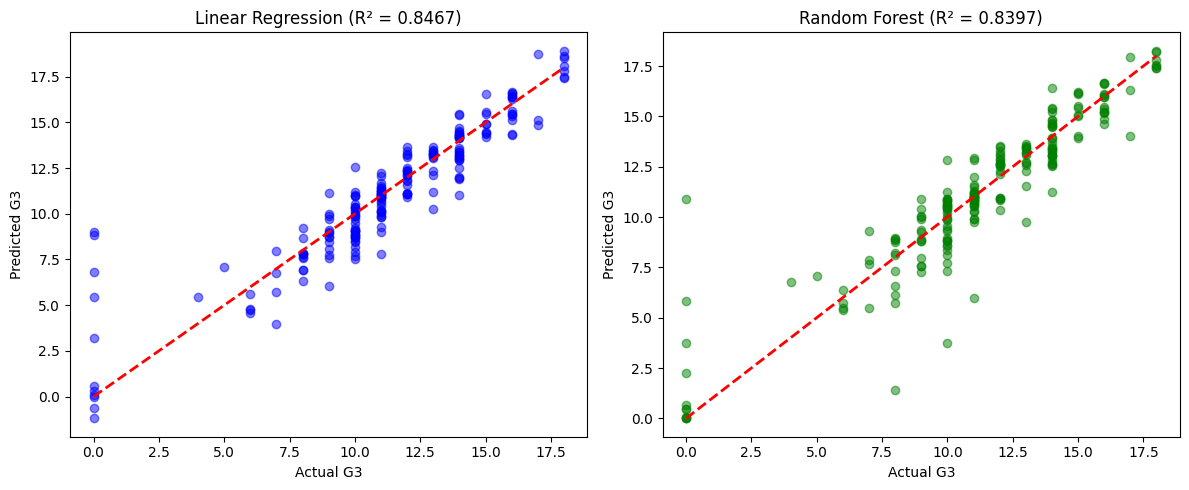

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, lr_pred, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual G3')
axes[0].set_ylabel('Predicted G3')
axes[0].set_title(f'Linear Regression (R² = {r2_score(y_test, lr_pred):.4f})')

axes[1].scatter(y_test, rf_pred, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual G3')
axes[1].set_ylabel('Predicted G3')
axes[1].set_title(f'Random Forest (R² = {r2_score(y_test, rf_pred):.4f})')

plt.tight_layout()
plt.show()

## 8. Feature Importances

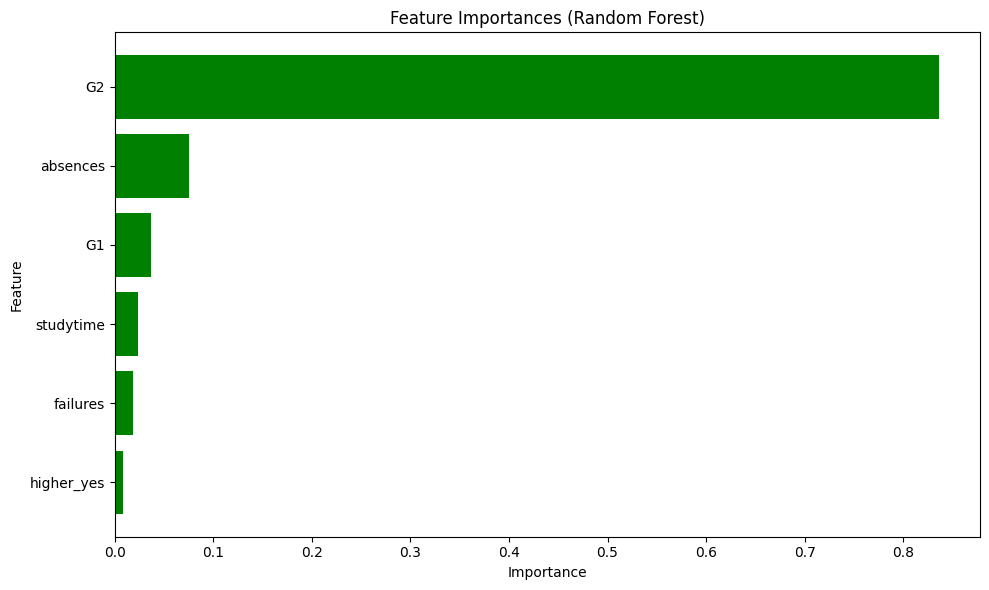


Feature Importances:
   Feature  Importance
        G2    0.836048
  absences    0.075660
        G1    0.037149
 studytime    0.024059
  failures    0.018191
higher_yes    0.008893


In [11]:
feature_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importances:")
print(feature_importance.to_string(index=False))

## 9. Sanity Check — Absences Direction

Verify that increasing absences decreases the predicted grade.

In [12]:
test_low = pd.DataFrame([[10, 10, 0, 2, 0, 1]], columns=FEATURES)
test_high = pd.DataFrame([[10, 10, 50, 2, 0, 1]], columns=FEATURES)

pred_low = rf_model.predict(scaler.transform(test_low))[0]
pred_high = rf_model.predict(scaler.transform(test_high))[0]

print(f"Absences = 0  → Predicted G3: {pred_low:.2f}")
print(f"Absences = 50 → Predicted G3: {pred_high:.2f}")

if pred_low >= pred_high:
    print("\n✓ More absences → lower/equal grade (correct!)")
else:
    print("\n✗ WARNING: More absences → higher grade (unexpected)")

Absences = 0  → Predicted G3: 10.30
Absences = 50 → Predicted G3: 10.11

✓ More absences → lower/equal grade (correct!)


## 10. Export Predictions

In [13]:
predictions_df = pd.DataFrame({
    'Actual_G3': y_test.values,
    'Linear_Regression_Predicted': lr_pred.round(2),
    'Random_Forest_Predicted': rf_pred.round(2)
})

test_features = X_test.reset_index(drop=True)
export_df = pd.concat([test_features, predictions_df], axis=1)

export_df.to_csv('predictions.csv', index=False)
print(f"Predictions exported to 'predictions.csv'")
print(f"Total records: {len(export_df)}")
print("\nPreview:")
export_df[['Actual_G3', 'Linear_Regression_Predicted', 'Random_Forest_Predicted']].head(10)

Predictions exported to 'predictions.csv'
Total records: 209

Preview:


,Actual_G3,Linear_Regression_Predicted,Random_Forest_Predicted
0,11,11.03,11.17
1,10,9.21,9.98
2,14,14.23,13.93
3,9,9.10,10.03
4,10,10.55,10.75
5,0,3.19,0.00
6,14,14.34,15.20
7,10,10.21,10.33
8,12,11.85,12.84
9,11,10.14,10.67


## 11. Save Model Artifacts for Streamlit Deployment

In [14]:
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(FEATURES, f)

print("✓ Saved: random_forest_model.pkl, scaler.pkl, feature_columns.pkl")
print("\nNow run: streamlit run main.py")

✓ Saved: random_forest_model.pkl, scaler.pkl, feature_columns.pkl

Now run: streamlit run main.py
